# Projet 8 :Déployez un modèle dans le cloud

Etapes du projet:

<u>Ce projet sera divisé en 2 parties</u>:

1. Déploiement de la solution en local
2. Déploiement de la solution dans le cloud

# 1. Déploiement de la solution en local


## 1.1 Environnement de travail

Pour des raisons de simplicité, nous développons dans un environnement <br />
Linux Unbuntu (exécuté depuis une machine Windows dans une machine virtuelle)



## 1.2 Installation des packages


In [ ]:
!pip install Pandas pillow tensorflow pyspark pyarrow

## 1.3 Import des librairies

In [ ]:
import pandas as pd
from PIL import Image
import numpy as np
import io
import os

import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split
from pyspark.sql import SparkSession

2023-04-02 15:44:06.361603: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 1.4 Définition des PATH pour charger les images <br /> et enregistrer les résultats

Nous n'utilisons qu'un extrait de **300 images** à traiter dans cette <br />
première version en local.<br />
L'extrait des images à charger est stockée dans le dossier **Test1**.<br />
Nous enregistrerons le résultat de notre traitement <br />
dans le dossier "**Results**"

In [ ]:
PATH = os.getcwd()
PATH_Data = PATH+'/data/Test1'
PATH_Result = PATH+'/data/Results'
print('PATH:        '+\
      PATH+'\nPATH_Data:   '+\
      PATH_Data+'\nPATH_Result: '+PATH_Result)

PATH:        /home/brahim/Bureau/Projet_8/Mode_opératoire/P8_Mode_opératoire
PATH_Data:   /home/brahim/Bureau/Projet_8/Mode_opératoire/P8_Mode_opératoire/data/Test1
PATH_Result: /home/brahim/Bureau/Projet_8/Mode_opératoire/P8_Mode_opératoire/data/Results


## 1.5 Création de la SparkSession

In [ ]:
spark = (SparkSession
             .builder
             .appName('P8')
             .master('local')
             .config("spark.sql.parquet.writeLegacyFormat", 'true')
             .getOrCreate()
)

23/04/02 15:45:24 WARN Utils: Your hostname, brahim-VirtualBox resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
23/04/02 15:45:24 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/04/02 15:45:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:
sc = spark.sparkContext

<u>Affichage des informations de Spark en cours d'execution</u> :

In [ ]:
spark

## 1.6 Traitement des données

### 1.6.1 Chargement des données

In [ ]:
images = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load(PATH_Data)

<u>Affichage des 5 premières images contenant</u> :
 - le path de l'image
 - la date et heure de sa dernière modification
 - sa longueur
 - son contenu encodé en valeur hexadécimal

<u>Je ne conserve que le **path** de l'image et j'ajoute <br />
    une colonne contenant les **labels** de chaque image</u> :

In [ ]:
images = images.withColumn('label', element_at(split(images['path'], '/'),-2))
print(images.printSchema())
print(images.select('path','label').show(5,False))

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None
+---------------------------------------------------------------------------------------------------------+----------+
|path                                                                                                     |label     |
+---------------------------------------------------------------------------------------------------------+----------+
|file:/home/brahim/Bureau/Projet_8/Mode_opératoire/P8_Mode_opératoire/data/Test1/Watermelon/r_106_100.jpg|Watermelon|
|file:/home/brahim/Bureau/Projet_8/Mode_opératoire/P8_Mode_opératoire/data/Test1/Watermelon/r_178_100.jpg|Watermelon|
|file:/home/brahim/Bureau/Projet_8/Mode_opératoire/P8_Mode_opératoire/data/Test1/Raspberry/77_100.jpg    |Raspberry |
|file:/home/brahim/Bureau/Projet_8/Mode_opératoire/P8_Mode_opératoire/data/

In [ ]:
model = MobileNetV2(weights='imagenet',
                    include_top=True,
                    input_shape=(224, 224, 3))

2023-04-02 15:46:26.127425: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 15:46:26.137864: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [ ]:
new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)

Affichage du résumé de notre nouveau modèle où nous constatons <br />
que <u>nous récupérons bien en sortie un vecteur de dimension (1, 1, 1280)</u> :

In [ ]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

Tous les workeurs doivent pouvoir accéder au modèle ainsi qu'à ses poids. <br />
Une bonne pratique consiste à charger le modèle sur le driver puis à diffuser <br />
ensuite les poids aux différents workeurs.

In [ ]:
brodcast_weights = sc.broadcast(new_model.get_weights())

<u>Mettons cela sous forme de fonction</u> :

In [ ]:
def model_fn():
    """
    Returns a MobileNetV2 model with top layer removed 
    and broadcasted pretrained weights.
    """
    model = MobileNetV2(weights='imagenet',
                        include_top=True,
                        input_shape=(224, 224, 3))
    for layer in model.layers:
        layer.trainable = False
    new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)
    new_model.set_weights(brodcast_weights.value)
    return new_model

In [ ]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)

def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).

    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

/home/brahim/anaconda3/lib/python3.9/site-packages/pyspark/sql/pandas/functions.py:394: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


In [ ]:
# spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1024")

Nous pouvons maintenant exécuter la featurisation sur l'ensemble de notre DataFrame Spark.<br />

Notre jeu de données de **Test** contient **22819 images**. <br />
Cependant, dans l'exécution en mode **local**, <br />
nous <u>traiterons un ensemble réduit de **330 images**</u>.

In [ ]:
features_df = images.repartition(20).select(col("path"),
                                            col("label"),
                                            featurize_udf("content").alias("features")
                                           )

<u>Rappel du PATH où seront inscrits les fichiers au format "**parquet**" <br />
contenant nos résultats, à savoir, un DataFrame contenant 3 colonnes</u> :
 1. Path des images
 2. Label de l'image
 3. Vecteur de caractéristiques de l'image

In [ ]:
print(PATH_Result)

/home/brahim/Bureau/Projet_8/Mode_opératoire/P8_Mode_opératoire/data/Results


In [ ]:
features_df.columns

['path', 'label', 'features']

In [ ]:
# Séléction de la colonne des features
df1 = features_df.select('features')

In [ ]:
df1.show(5)

2023-04-02 15:47:09.768560: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 15:47:12.001534: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 15:47:12.006819: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
1/1 [==============================] - 3s 3s/step


+--------------------+
|            features|
+--------------------+
|[0.6780357, 0.532...|
|[0.7053601, 1.881...|
|[0.5911318, 0.073...|
|[0.14640844, 0.07...|
|[0.044699065, 0.1...|
+--------------------+
only showing top 5 rows



In [ ]:
print(type(df1))

<class 'pyspark.sql.dataframe.DataFrame'>


In [ ]:
from pyspark.ml.functions import array_to_vector
df2 =df1.withColumn("features_vectorized", array_to_vector("features"))

In [ ]:
df2.show(5)

2023-04-02 15:47:43.297272: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 15:47:45.024394: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 15:47:45.027708: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
1/1 [==============================] - 2s 2s/step


+--------------------+--------------------+
|            features| features_vectorized|
+--------------------+--------------------+
|[0.6780357, 0.532...|[0.67803567647933...|
|[0.7053601, 1.881...|[0.70536011457443...|
|[0.5911318, 0.073...|[0.59113180637359...|
|[0.14640844, 0.07...|[0.14640843868255...|
|[0.044699065, 0.1...|[0.04469906538724...|
+--------------------+--------------------+
only showing top 5 rows



In [ ]:
df2.select('features_vectorized').show(5)

2023-04-02 15:47:58.854553: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 15:48:00.608712: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 15:48:00.611007: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


+--------------------+
| features_vectorized|
+--------------------+
|[0.67803567647933...|
|[0.70536011457443...|
|[0.59113180637359...|
|[0.14640843868255...|
|[0.04469906538724...|
+--------------------+
only showing top 5 rows



1/1 [==============================] - 2s 2s/step


In [ ]:
print(type(df2.select('features_vectorized')))

<class 'pyspark.sql.dataframe.DataFrame'>


#### Nous normalisons les caractéristiques, on spécifie la colonne transformée en vecteur comme entité d'entrée

In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
scaler = StandardScaler(
    inputCol = 'features_vectorized', 
    outputCol = 'scaledFeatures',
    withMean = True,
    withStd = True
).fit(df2.select('features_vectorized'))

# when we transform the dataframe, the old
# feature will still remain in it
df_scaled = scaler.transform(df2.select('features_vectorized'))
df_scaled.show(6)

2023-04-02 15:48:48.254791: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 15:48:50.273673: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 15:48:50.277095: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
1/1 [==============================] - 2s 2s/step==============>  (19 + 1) / 20]


+--------------------+--------------------+
| features_vectorized|      scaledFeatures|
+--------------------+--------------------+
|[0.67803567647933...|[0.21997626526984...|
|[0.70536011457443...|[0.26452103656417...|
|[0.59113180637359...|[0.07830407406207...|
|[0.14640843868255...|[-0.6466916471344...|
|[0.04469906538724...|[-0.8125000255597...|
|[1.12304162979125...|[0.94543266243014...|
+--------------------+--------------------+
only showing top 6 rows



1/1 [==============================] - 1s 1s/step


#### Application de la PCA

In [ ]:
n_components = 2
pca = PCA(
    k = n_components, 
    inputCol = 'scaledFeatures', 
    outputCol = 'pcaFeatures'
).fit(df_scaled)

df_pca = pca.transform(df_scaled)
print('Explained Variance Ratio', pca.explainedVariance.toArray())
df_pca.show(6)

2023-04-02 15:50:06.092554: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 15:50:08.210827: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 15:50:08.218358: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
1/1 [==============================] - 2s 2s/step
2023-04-02 15:50:12.002058: I tensorflow/core/platfor

23/04/02 15:52:38 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
23/04/02 15:52:38 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK
Explained Variance Ratio [0.0845372  0.05158569]


1/1 [==============================] - 2s 2s/step                   (0 + 1) / 1]


+--------------------+--------------------+--------------------+
| features_vectorized|      scaledFeatures|         pcaFeatures|
+--------------------+--------------------+--------------------+
|[0.67803567647933...|[0.21997626526984...|[8.84848422847595...|
|[0.70536011457443...|[0.26452103656417...|[-2.3150464209974...|
|[0.59113180637359...|[0.07830407406207...|[10.0378108821016...|
|[0.14640843868255...|[-0.6466916471344...|[2.08328344909395...|
|[0.04469906538724...|[-0.8125000255597...|[-2.3116593457641...|
|[1.12304162979125...|[0.94543266243014...|[0.84376896987801...|
+--------------------+--------------------+--------------------+
only showing top 6 rows



In [ ]:
pca = PCA(
    k = n_components, 
    inputCol = 'scaledFeatures', 
    outputCol = 'pcaFeatures'
).fit(df_scaled)

2023-04-02 16:09:26.213718: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 16:09:28.178680: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 16:09:28.182834: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
1/1 [==============================] - 2s 2s/step
2023-04-02 16:09:33.224608: I tensorflow/core/platfor

[0.08453719537796141,0.051585692547817974,0.04787948146855735,0.03587103259600904,0.035577098570308795,0.03237242204268703,0.026122947617333754,0.023709045249520003,0.021005984970837433,0.020383286921786377,0.019370965731440145,0.01866648985175147,0.017888515773733734,0.01649115784644963,0.016070847600757495,0.015089501540156352,0.01476070147603358,0.014090703213243874,0.013342719705305307,0.012694774796449496,0.012138951837855955,0.011842533187552459,0.011226699860218963,0.010870367157737903,0.010781591596295178,0.010463600563700052,0.009979654617429352,0.009483083969532973,0.009268349143381333,0.009116388064956711,0.008682888004698667,0.008571927631332016,0.008380039570177323,0.008272791838004874,0.008048758006358852,0.007905040965348482,0.007632860290929672,0.007364983845113812,0.00704901369639306,0.00684541397457339,0.006629024860899899,0.006496024464079754,0.006445600202006646,0.006325097311211824,0.006074686626181414,0.00586658914782439,0.005759681152558425,0.005685390561053762,0

Text(0, 0.5, 'cumulative explained variance')

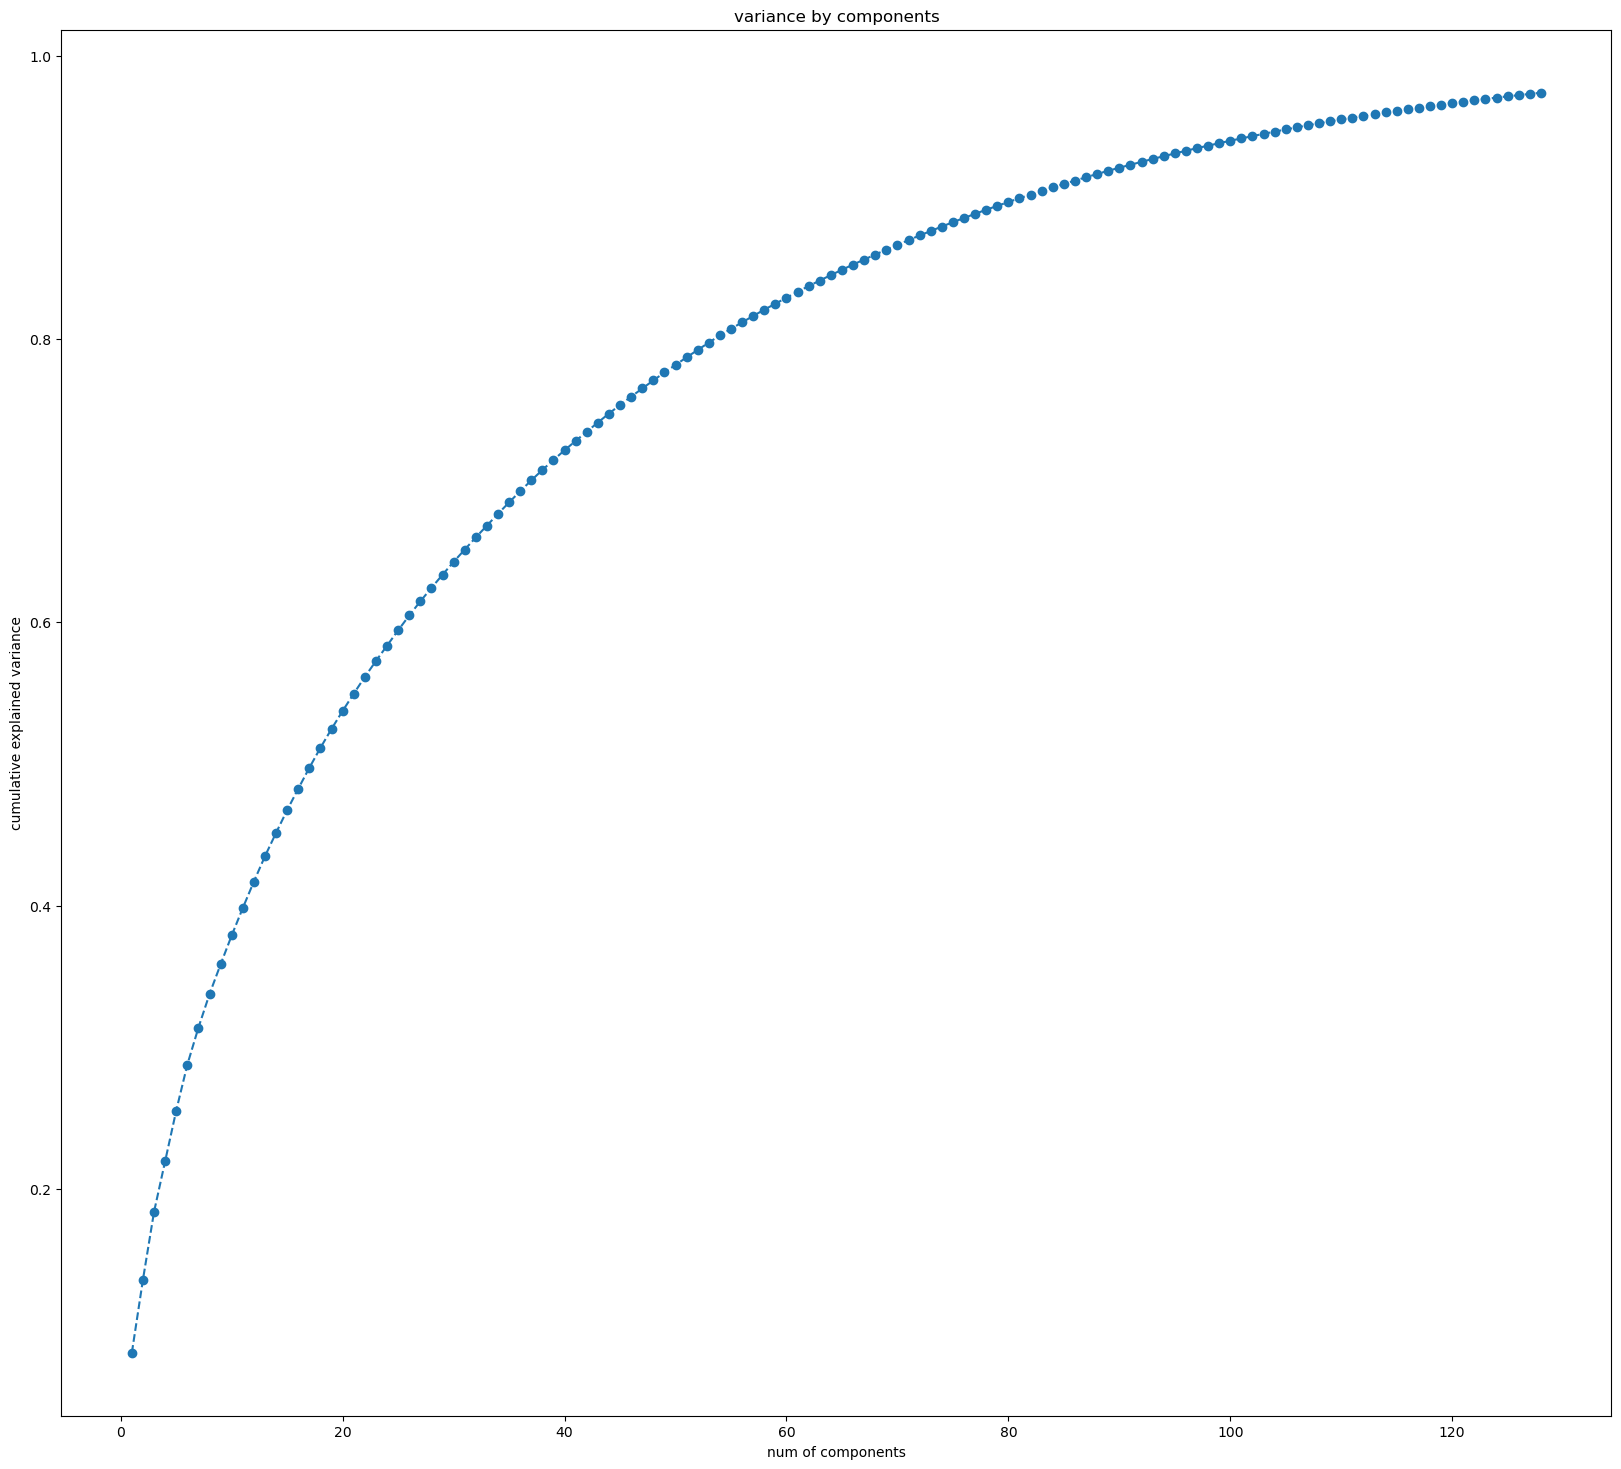

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import PCA
from matplotlib import pyplot as plt

# used vector assembler to create the input the vector 
vectorAssembler = VectorAssembler(inputCols=['inputCol1', 'inputCol2', 'inputCol3', 'inputCol4'], outputCol='pcaInput')


pca = PCA(k=128, inputCol="scaledFeatures", outputCol="pcaFeatures") # here I Have defined maximum number of features that I have
pcaModel = pca.fit(df_scaled) # fit the data to pca to make the model
print(pcaModel.explainedVariance) # here it will explain the variances
cumValues = pcaModel.explainedVariance.cumsum() # get the cumulative values
# plot the graph 
plt.figure(figsize=(20,18))
plt.plot(range(1,129), cumValues, marker = 'o', linestyle='--')
plt.title('variance by components')
plt.xlabel('num of components')
plt.ylabel('cumulative explained variance')

<u>Enregistrement des données traitées au format "**parquet**"</u> :

In [ ]:
features_df.write.mode("overwrite").parquet(PATH_Result)

2023-04-02 16:16:02.424860: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 16:16:05.006807: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 16:16:05.014690: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
1/1 [==============================] - 2s 2s/step==============>  (19 + 1) / 20]


## 1.6.2. Chargement des données enregistrées et validation du résultat

<u>On charge les données fraichement enregistrées dans un **DataFrame Pandas**</u> :

In [ ]:
df = pd.read_parquet(PATH_Result, engine='pyarrow')

<u>On affiche les 5 premières lignes du DataFrame</u> :

In [ ]:
df.head()

,path,label,features
0,file:/home/brahim/Bureau/Projet_8/Mode_opérat...,Limes,"[0.0, 0.0, 0.9149899, 0.0, 0.0, 0.0, 0.0471317..."
1,file:/home/brahim/Bureau/Projet_8/Mode_opérat...,Rambutan,"[0.006145857, 3.386788, 0.0, 1.1772908, 0.0774..."
2,file:/home/brahim/Bureau/Projet_8/Mode_opérat...,Guava,"[0.06614286, 0.0, 0.2890422, 0.0, 0.20765495, ..."
3,file:/home/brahim/Bureau/Projet_8/Mode_opérat...,Huckleberry,"[0.2415631, 1.5080878, 0.061693404, 0.02235253..."
4,file:/home/brahim/Bureau/Projet_8/Mode_opérat...,Tomato not Ripened,"[0.14640844, 0.07590987, 0.065136075, 0.0, 0.0..."


<u>On valide que la dimension du vecteur de caractéristiques des images est bien de dimension 1280</u> :

In [ ]:
df.loc[0,'features'].shape

(1280,)

# 2. Déploiement de la solution sur le cloud

Maintenant que nous avons vérifié que notre solution fonctionne, <br />
il est temps de la <u>déployer à plus grande échelle sur un vrai cluster de machines</u>.

 
### Choix du prestataire cloud : AWS (**Amazon Web Services** )


#### * solution technique : EMR



#### * stockage des données : Amazon S3


### 2.1 Démarrage de la session Spark

In [ ]:
# L'exécution de cette cellule démarre l'application Spark

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
0,application_1680386371313_0001,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<u>Affichage des informations sur la session en cours et liens vers Spark UI</u> :

In [ ]:
%%info

ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
0,application_1680386371313_0001,pyspark,idle,Link,Link,None,✔


### 2.2 Import des librairies

In [ ]:
import pandas as pd
import numpy as np
import io
import os
import tensorflow as tf
from PIL import Image
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### 2.3 Définition des PATH pour charger les images et enregistrer les résultats

Nous accédons directement à nos **données sur S3** comme si elles étaient **stockées localement**.

In [ ]:
PATH = 's3://oc-projet8-data'
PATH_Data = PATH+'/test'
PATH_Result = PATH+'/Results'
print('PATH:        '+\
      PATH+'\nPATH_Data:   '+\
      PATH_Data+'\nPATH_Result: '+PATH_Result)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

PATH:        s3://oc-projet8-data
PATH_Data:   s3://oc-projet8-data/test
PATH_Result: s3://oc-projet8-data/Results

### 2.4 Traitement des données

#### 2.4.1Chargement des données

In [ ]:
images = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load(PATH_Data)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
images.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-------------------+------+--------------------+
|                path|   modificationTime|length|             content|
+--------------------+-------------------+------+--------------------+
|s3://oc-projet8-d...|2023-03-22 09:26:44|  7353|[FF D8 FF E0 00 1...|
|s3://oc-projet8-d...|2023-03-22 09:26:44|  7350|[FF D8 FF E0 00 1...|
|s3://oc-projet8-d...|2023-03-22 09:26:44|  7349|[FF D8 FF E0 00 1...|
|s3://oc-projet8-d...|2023-03-22 09:26:44|  7348|[FF D8 FF E0 00 1...|
|s3://oc-projet8-d...|2023-03-22 09:26:46|  7328|[FF D8 FF E0 00 1...|
+--------------------+-------------------+------+--------------------+
only showing top 5 rows

<u>Je ne conserve que le **path** de l'image et j'ajoute <br />
    une colonne contenant les **labels** de chaque image</u> :

In [ ]:
images = images.withColumn('label', element_at(split(images['path'], '/'),-2))
print(images.printSchema())
print(images.select('path','label').show(5,False))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None
+--------------------------------------------------+----------+
|path                                              |label     |
+--------------------------------------------------+----------+
|s3://oc-projet8-data/test/Watermelon/r_106_100.jpg|Watermelon|
|s3://oc-projet8-data/test/Watermelon/r_109_100.jpg|Watermelon|
|s3://oc-projet8-data/test/Watermelon/r_108_100.jpg|Watermelon|
|s3://oc-projet8-data/test/Watermelon/r_107_100.jpg|Watermelon|
|s3://oc-projet8-data/test/Watermelon/r_95_100.jpg |Watermelon|
+--------------------------------------------------+----------+
only showing top 5 rows

None

#### 2.4.2 Préparation du modèle

In [ ]:
model = MobileNetV2(weights='imagenet',
                    include_top=True,
                    input_shape=(224, 224, 3))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

14536120/14536120 [==============================] - 1s 0us/step

In [ ]:
new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
brodcast_weights = sc.broadcast(new_model.get_weights())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
new_model.summary()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [ ]:
def model_fn():
    """
    Returns a MobileNetV2 model with top layer removed 
    and broadcasted pretrained weights.
    """
    model = MobileNetV2(weights='imagenet',
                        include_top=True,
                        input_shape=(224, 224, 3))
    for layer in model.layers:
        layer.trainable = False
    new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)
    new_model.set_weights(brodcast_weights.value)
    return new_model

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)

def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).

    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

/mnt1/yarn/usercache/livy/appcache/application_1680386371313_0001/container_1680386371313_0001_01_000001/pyspark.zip/pyspark/sql/pandas/functions.py:398: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.

#### 2.4.3 Exécutions des actions d'extractions de features

In [ ]:
# spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1024")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
features_df = images.repartition(24).select(col("path"),
                                            col("label"),
                                            featurize_udf("content").alias("features")
                                           )

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
features_df.columns

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['path', 'label', 'features']

In [ ]:
# Séléction de la colonne des features
df1 = features_df.select('features')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
df1.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+
|            features|
+--------------------+
|[0.65066034, 0.23...|
|[0.036237378, 0.1...|
|[0.015392984, 4.6...|
|[0.0, 4.519895, 0...|
|[0.0, 4.8245773, ...|
+--------------------+
only showing top 5 rows

In [ ]:
print(type(df1))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<class 'pyspark.sql.dataframe.DataFrame'>

In [ ]:
from pyspark.ml.functions import array_to_vector
df2 =df1.withColumn("features_vectorized", array_to_vector("features"))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
df2.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+
|            features| features_vectorized|
+--------------------+--------------------+
|[0.65066034, 0.23...|[0.65066033601760...|
|[0.036237378, 0.1...|[0.03623737767338...|
|[0.015392984, 4.6...|[0.01539298426359...|
|[0.0, 4.519895, 0...|[0.0,4.5198950767...|
|[0.0, 4.8245773, ...|[0.0,4.8245773315...|
+--------------------+--------------------+
only showing top 5 rows

In [ ]:
print(type(df2.select('features_vectorized')))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<class 'pyspark.sql.dataframe.DataFrame'>

#### Nous normalisons les caractéristiques, on spécifie la colonne transformée en vecteur comme entité d'entrée

#### Standardisation

In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
scaler = StandardScaler(
    inputCol = 'features_vectorized', 
    outputCol = 'scaledFeatures',
    withMean = True,
    withStd = True
).fit(df2.select('features_vectorized'))

# when we transform the dataframe, the old
# feature will still remain in it
df_scaled = scaler.transform(df2.select('features_vectorized'))
df_scaled.show(6)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+
| features_vectorized|      scaledFeatures|
+--------------------+--------------------+
|[0.65066033601760...|[0.44830321802419...|
|[0.03623737767338...|[-0.6902513617676...|
|[0.01539298426359...|[-0.7288770010888...|
|[0.0,4.5198950767...|[-0.7574009234000...|
|[0.0,4.8245773315...|[-0.7574009234000...|
|[0.08464313298463...|[-0.6005532252487...|
+--------------------+--------------------+
only showing top 6 rows

#### Application de la PCA

In [ ]:
n_components = 2
pca = PCA(
    k = n_components, 
    inputCol = 'scaledFeatures', 
    outputCol = 'pcaFeatures'
).fit(df_scaled)

df_pca = pca.transform(df_scaled)
print('Explained Variance Ratio', pca.explainedVariance.toArray())
df_pca.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Explained Variance Ratio [0.07672073 0.05040702]
+--------------------+--------------------+--------------------+
| features_vectorized|      scaledFeatures|         pcaFeatures|
+--------------------+--------------------+--------------------+
|[0.65066033601760...|[0.44830321802419...|[-17.287625650450...|
|[0.03623737767338...|[-0.6902513617676...|[-13.025203309278...|
|[0.01539298426359...|[-0.7288770010888...|[-9.9118570262535...|
|[0.0,4.5198950767...|[-0.7574009234000...|[-12.964916084824...|
|[0.0,4.8245773315...|[-0.7574009234000...|[-6.2448371156153...|
+--------------------+--------------------+--------------------+
only showing top 5 rows

#### Enregistrement dans le bucket s3 des vecteurs aprés réduction de la dimension par la PCA

In [ ]:
PATH_PCA = PATH+'/pca'
print(PATH_PCA)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

s3://oc-projet8-data/pca

In [ ]:
(df_pca.select("pcaFeatures")).write.mode("overwrite").parquet(PATH_PCA)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
print(PATH_Result)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

s3://oc-projet8-data/Results

In [ ]:
features_df.write.mode("overwrite").parquet(PATH_Result)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### 2.4.4 Chargement des données enregistrées et validation du résultat

In [ ]:
df = pd.read_parquet(PATH_Result, engine='pyarrow')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
df.head()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                                           path  ...                                           features
0    s3://p8-data/Test/Watermelon/r_174_100.jpg  ...  [0.0059991637, 0.44703647, 0.0, 0.0, 3.3713572...
1  s3://p8-data/Test/Pineapple Mini/128_100.jpg  ...  [0.0146466885, 4.080593, 0.055877004, 0.0, 0.0...
2  s3://p8-data/Test/Pineapple Mini/137_100.jpg  ...  [0.0, 4.9659867, 0.0, 0.0, 0.0, 0.0, 0.5144821...
3      s3://p8-data/Test/Watermelon/275_100.jpg  ...  [0.22511952, 0.07235509, 0.0, 0.0, 1.690149, 0...
4      s3://p8-data/Test/Watermelon/271_100.jpg  ...  [0.3286234, 0.18830013, 0.0, 0.0, 1.9123534, 0...

[5 rows x 3 columns]

In [ ]:
df.loc[0,'features'].shape

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(1280,)

In [ ]:
df.shape

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(22688, 3)